In [1]:
# script to run simulations of stream peppering
import os, os.path
import csv
import time
import pickle
import matplotlib
#matplotlib.use('agg')
import numpy
from scipy import integrate, interpolate
from optparse import OptionParser
from galpy.util import bovy_conversion
import phx_util
from scipy.integrate import quad
from scipy.optimize import brentq
import glob
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit
from scipy import ndimage, signal, interpolate
from numpy.polynomial import Polynomial
from astropy.coordinates import SkyCoord

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)


Populating the interactive namespace from numpy and matplotlib


In [2]:
with open('../phx_t64sampling_trailing.pkl','rb') as savefile:
    sdf_pepper_t= pickle.load(savefile,encoding='latin1')
    
with open('../phx_smooth_trailing.pkl','rb') as savefile:
    sdf_smooth_t= pickle.load(savefile,encoding='latin1')
    
def lb_to_lambdabeta(ll,bb):
    lbSkyCoord=SkyCoord(l=ll*u.degree,b=bb*u.degree,frame='galactic')
    phx_coord = lbSkyCoord.transform_to(phx_util.Phoenix)
    lamda = phx_coord.Lambda.value
    beta = phx_coord.Beta.value
    return (lamda,beta)
    

def compute_obs_density_phx(lamda,apars,dens_apar,Omega): #lambda spelled wrong, bc of lambda func
    
    apar_edge=[]
    lamda_edge=[]

    abw0=apars[1]-apars[0]
    apar_edge.append(apars[0]-(abw0/2.))

    lamdabw0=lamda[1]-lamda[0]
    lamda_edge.append(lamda[0]-(lamdabw0/2.))
    
    for ii in range(len(apars)-1):
        abw=apars[ii+1]-apars[ii]
        lamdabw=lamda[ii+1]-lamda[ii]
        apar_edge.append(apars[ii]+abw/2.)
        lamda_edge.append(lamda[ii]+lamdabw/2.)
    
    abw_last=apars[len(apars)-1]-apars[len(apars)-2]
    apar_edge.append(apars[len(apars)-1]+(abw_last/2.))

    lamdabw_last=lamda[len(lamda)-1]-lamda[len(lamda)-2]
    lamda_edge.append(lamda[len(lamda)-1]+(lamdabw_last/2.))
    #print (lamda_edge)
    #compute the Jacobian d(apar)/d(lamda) using finite difference method
    dapar_dlamda=np.fabs(numpy.diff(apar_edge)/numpy.diff(lamda_edge))
    #print (dapar_dlamda)
   
    #Interpolate dens(apar)
    ipdens_apar= interpolate.InterpolatedUnivariateSpline(apars,dens_apar)

    #Interpolate apar(lamda)
    if lamda[1] < lamda[0] : # ad-hoc way of checking whether increasing or decreasing
        iplamda= interpolate.InterpolatedUnivariateSpline(lamda[::-1],apars[::-1])
        #Interpolate Jacobian
        ipdapar_dlamda=interpolate.InterpolatedUnivariateSpline(lamda[::-1],dapar_dlamda[::-1])
        #Interpolate density(lamda) by multiplying by jacobian
        dens_lamda=interpolate.InterpolatedUnivariateSpline(lamda[::-1],\
                                                            ipdens_apar(iplamda(lamda[::-1]))*ipdapar_dlamda(lamda[::-1]))
        
    else :
        iplamda= interpolate.InterpolatedUnivariateSpline(lamda,apars)
        #Interpolate Jacobian
        ipdapar_dlamda=interpolate.InterpolatedUnivariateSpline(lamda,dapar_dlamda)
        #Interpolate density(lamda) by multiplying by jacobian
        dens_lamda=interpolate.InterpolatedUnivariateSpline(lamda,ipdens_apar(iplamda(lamda))*ipdapar_dlamda(lamda))
       
    return (dens_lamda(lamda))


def compute_obs_dens_from_file_4bin(fname,lamda_out,sdf_pepper):
    """
    Function to convert simulated density and apar to observed density and density contrast
    
    """
    dat=np.loadtxt(fname)
    xcdm1=dat[:,0][0]
    xcdm2=dat[:,1][0]
    xcdm3=dat[:,2][0]
    xcdm4=dat[:,3][0]
    apars=dat[:,4]
    dens_smooth=dat[:,5]
    dens_apar=dat[:,6]
    Omega=dat[:,8]
    mT= sdf_pepper.meanTrack(apars,_mO=Omega,coord='lb')
    lamda,_ = lb_to_lambdabeta(mT[0],mT[1])
    dens_lamda = compute_obs_density_phx(lamda,apars,dens_apar,Omega)
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(lamda,apars)
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens_apar/dens_smooth)
    
    return (xcdm1,xcdm2,xcdm3,xcdm4,lamda,dens_lamda,lamda_out,ipdens(ipll(lamda_out)))

#power spectrum from dens already converted to observed coordinates
def compute_pk_sim(p1,dens_cont):
    
    px,py= signal.csd(dens_cont,dens_cont,fs=1./(p1[1]-p1[0]),scaling='spectrum',nperseg=len(p1))
    py= py.real
    px = 1./px
    py = numpy.sqrt(py*(p1[-1]-p1[0]))
                    
    return (px,py)

def set_ranges_and_labels_dens():
    #bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\Lambda}\,(\mathrm{deg})$')
    ylabel(r'$\sqrt{P_{\delta\delta}(k_{\Lambda})}$')
    ylim(0.01,20.)
    xlim(1.,120.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None  

def compute_nden_mock(fname,nmodel=0,polydeg=3):
    Lambdas=np.linspace(280.,299.9,200)
    Ndn=np.loadtxt(fname)[nmodel]
    #print (np.sum(Ndn))
    Ndn_err=numpy.sqrt(Ndn)
       
    pp= Polynomial.fit(Lambdas,Ndn,deg=polydeg,w=1/(Ndn_err))
    nden=Ndn/pp(np.array(Lambdas))
    nden_err=np.sqrt(Ndn)/pp(np.array(Lambdas))
       
    return (Lambdas,Ndn,Ndn_err,nden,nden_err,pp(np.array(Lambdas)))

def compute_pk_mock(fname="",nmodel=0):
    
    #Lambdas=np.linspace(280.,299.9,200)      
    Lambdas,_,_,nden,nden_err,_ = compute_nden_mock(fname,nmodel=nmodel,polydeg=3)
     
    px_dat,py_dat= signal.csd(nden,nden_err,fs=1./(Lambdas[1]-Lambdas[0]),scaling='spectrum',nperseg=len(Lambdas))
    py_dat= py_dat.real
    px_dat= 1./px_dat
    py_dat= numpy.sqrt(py_dat*(Lambdas[-1]-Lambdas[0]))
           
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err_dat= numpy.empty((nerrsim,len(px_dat)))

    ppy_noise=numpy.empty((nerrsim,len(px_dat)))

    for ii in range(nerrsim):
        tmock= nden_err*numpy.random.normal(size=len(Lambdas))
        tmock_noise= nden + nden_err*numpy.random.normal(size=len(Lambdas))
        ppy_err_dat[ii]= signal.csd(tmock,tmock,
                                fs=1./(Lambdas[1]-Lambdas[0]),scaling='spectrum',
                                nperseg=len(Lambdas))[1].real

        ppy_noise[ii]= signal.csd(tmock_noise,tmock_noise,
                                fs=1./(Lambdas[1]-Lambdas[0]),scaling='spectrum',
                                nperseg=len(Lambdas))[1].real

    py_err_dat= numpy.sqrt(numpy.median(ppy_err_dat,axis=0)*(Lambdas[-1]-Lambdas[0]))

    ppy_noise_median = numpy.sqrt(numpy.nanmedian(ppy_noise,axis=0)*(Lambdas[-1]-Lambdas[0]))
    #print (ppy_noise_median- py_dat)

    ppy_noise.sort(axis=0)

    ppy_noise_low = numpy.sqrt(ppy_noise[int(numpy.round(0.023*nerrsim))]*(Lambdas[-1]-Lambdas[0]))
    ppy_noise_high = numpy.sqrt(ppy_noise[int(numpy.round(0.977*nerrsim))]*(Lambdas[-1]-Lambdas[0]))
    
    return (px_dat,ppy_noise_median,ppy_noise_low,ppy_noise_high,py_err_dat)


def compute_length(lamda_all,dens_lamda_all,threshold=0.2):
          
    lamda = lamda_all[(lamda_all >= 280.) & (lamda_all <= 300.)]
    dens_lamda = dens_lamda_all[(lamda_all >= 280.) & (lamda_all <= 300.)]
    mean_den=np.mean(dens_lamda_all[(lamda_all >= 280.) & (lamda_all <= 282.)])
    ip_dens_lamda=interpolate.InterpolatedUnivariateSpline(lamda,dens_lamda)
        
    #first check if the density goes negative (due to interpolation of very small numbers.)
    if True in (dd < 0. for dd in dens_lamda):
        length = 0.
            
    else :
        lamda_fine=linspace(min(lamda),max(lamda),200)
        den_diff = ip_dens_lamda(lamda_fine) - threshold*mean_den
        
        if True in (d1<0. for d1 in den_diff):
            length = np.fabs(lamda_fine[argmin(np.fabs(den_diff))] - (280.))
        
        else :
            length = 17.6
                           
    return (length)


def compute_power_diff_4bins(dir='../dens_Omega/Phx_dens_Omega_4bins_randrate-1p5_1/',mod_no=0,modname="LSST_galaxiax10_new",\
                             len_threshold=0.2,RaoblackwellizeN=100):
                  
    
    mod = "../"+ modname
    lamda_out=np.linspace(280.,299.9,200)
    _,_,_,_,nden_err,_ = compute_nden_mock(mod,nmodel=mod_no) #import the dens_cont error
    px_dat,ppy_noise_median,ppy_noise_low,ppy_noise_high,py_err_dat = compute_pk_mock(fname=mod,\
                                                                                   nmodel=mod_no)
       
    fo = open('1testABC_4bin_{}{}_power_diff_trailing_lenthreshold{}_NRaoBlackwell{}.dat'.\
              format(modname,mod_no,len_threshold,RaoblackwellizeN),'w',newline='')
      
    fowriter= csv.writer(fo,delimiter=',')
    fowriter.writerow([pp for pp in px_dat[1:]])
      
    min_len=15.
    err_count=0
    
    with open('../phx_t64sampling_trailing.pkl','rb') as savefile:
        sdf_pepper= pickle.load(savefile,encoding='latin1')
    
    for fname in glob.glob(dir + '*.dat'):
                                  
        try:
            x1,x2,x3,x4,lamda,dens_lamda,lamda_out,dens_cont= \
            compute_obs_dens_from_file_4bin(fname,lamda_out,sdf_pepper)

            #compute length
            l_trail=compute_length(lamda,dens_lamda,threshold=len_threshold)
            mean_den_l=np.mean(dens_lamda[(lamda >= 280.) & (lamda <= 282.)])
            
            #if arm is shorter than observed then PENALIZE! 
            if l_trail < min_len  :
                #print (l10rate,l_trail, l_lead)
            #    print ("rejected")
            #    plt.figure(figsize=(8,6))
            #    plt.plot(lamda,dens_lamda)
            #    plt.hlines(0.2*mean_den_l,280,300)
            #    plt.vlines(280,0.,0.01)
            #    plt.show()
                prej = 100.*np.ones(len(px_dat)-1) #some huge number so that this gets rejected
                prej=np.insert(prej,0,[x1,x2,x3,x4])
            #    
                for ii in range(RaoblackwellizeN+1):
                    fowriter.writerow([p1 for p1 in prej])
                    

            #power spectrum from dens already converted to observed coordinates
            px_sim_tr,py_sim_tr = compute_pk_sim(lamda_out,dens_cont)

            diff_t=np.fabs(py_sim_tr[1:]-ppy_noise_median[1:])
            
            diff_t=np.insert(diff_t,0,[x1,x2,x3,x4])
            fowriter.writerow([pp for pp in diff_t])
            #print (x1,x2,x3,x4)
            #print (diff_t)
            #figsize(8,9)
            #loglog(px_dat,ppy_noise_median,color='black',zorder=10)
            #loglog(px_sim_tr,py_sim_tr)
            #show()


            for jj in range(RaoblackwellizeN):
                tdens_tr= dens_cont+numpy.random.normal(size=len(lamda_out))*nden_err

                px_sim_tr,py_sim_tr = compute_pk_sim(lam,tdens_tr,scaling='spectrum')
                diff_t=np.fabs(py_sim_tr[1:]-ppy_noise_median[1:])

                diff_t=np.insert(diff_t,0,[x1,x2,x3,x4])


                fowriter.writerow([pp for pp in diff_t])
                    
        except ValueError as e:
                pass
                err_count+=1
                #print (jj)
                #print (e)
                #os.rename(jj, trash_dir + fn) #move buggy realizations to trash 
    fo.flush()
    fo.close() 
    print (err_count)
    return None

0.07731206189220588
295.1454203788854
14.483153878869473


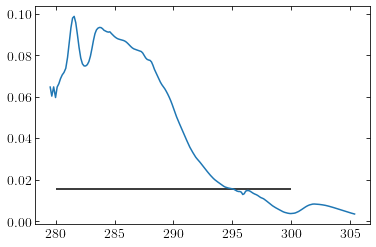

/home/nil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide



Text(0, 0.5, '$\\sqrt{P_{\\delta\\delta}(k_{\\Lambda})}$')

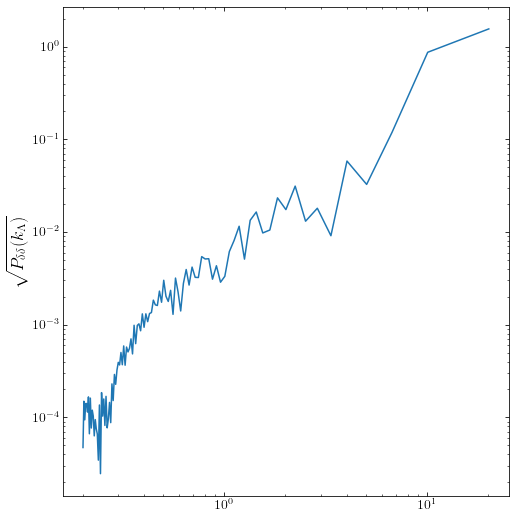

In [3]:
folder = "../dens_Omega/Phx_dens_Omega_4bins_10/"

fn = folder + "Phx_4bin_densOmega_onlysubhalo_Plummer_Mmin105_2.dat"

lam_out = np.linspace(280.,300,200)

_,_,_,_,lam,den_lam,_,den_cont_lam = compute_obs_dens_from_file_4bin(fn,lam_out,sdf_pepper_t)

print (np.mean(den_lam[lam_out<282.]))

print (lam[np.argmin(fabs(den_lam-0.2*np.mean(den_lam[lam<282.])))])

print (compute_length(lam,den_lam,threshold=0.2))


plt.figure()
plt.plot(lam,den_lam)
plt.hlines(0.2*np.mean(den_lam[lam<282.]),280,300)
plt.show()

_px,_py = compute_pk_sim(lam_out,den_cont_lam)

figsize(8,9)
loglog(_px,_py)
#set_ranges_and_labels_dens()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\Lambda})}$',fontsize=18)
    

In [ ]:
compute_power_diff_4bins(mod_no=0,modname="LSST_galaxiax10_new",\
                             len_threshold=0.2,RaoblackwellizeN=0)

In [4]:
#read the diff file and construct the posterior

mod_no=0
modname="LSST_galaxiax10_new"
RaoblackwellizeN = 0 

fname = '../1testABC_4bin_{}{}_power_diff_trailing_lenthreshold0.2_NRaoBlackwell{}.dat'\
.format(modname,mod_no,RaoblackwellizeN)


tol_tr_hi=0.3
tol_tr_med=0.2
tol_tr_lo=0.1
tol_tr_lo2=0.01
    

accepted_x1=[]
accepted_x2=[]
accepted_x3=[]
accepted_x4=[]


abc_diff_tr=np.loadtxt(fname,delimiter=',',skiprows=1)
    
for ii in range(len(abc_diff_tr)):
    #print (len(abc_diff_tr))
    xcdm1=abc_diff_tr[ii][0]
    xcdm2=abc_diff_tr[ii][1]
    xcdm3=abc_diff_tr[ii][2]
    xcdm4=abc_diff_tr[ii][3]

    #Trailing
    diff_tr_hi=abc_diff_tr[ii][4]
    diff_tr_med=abc_diff_tr[ii][5]
    diff_tr_lo=abc_diff_tr[ii][6]
    #diff_tr_lo2=abc_diff_tr[ii][7]


    #print (diff_tr_hi,diff_tr_med,diff_tr_lo)
    #
    if (diff_tr_hi < tol_tr_hi) and (diff_tr_med < tol_tr_med) and (diff_tr_lo < tol_tr_lo) :# and (diff_tr_lo2 < tol_tr_lo2):
        #print ("accept")
        #print (xcdm1,xcdm2,xcdm3,xcdm4)
        accepted_x1.append(np.log10(xcdm1))
        accepted_x2.append(np.log10(xcdm2))
        accepted_x3.append(np.log10(xcdm3))
        accepted_x4.append(np.log10(xcdm4))
            
        
print (len(accepted_x1))




16805


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


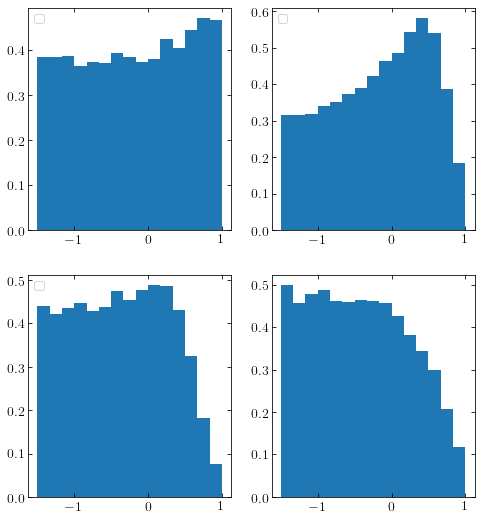

In [5]:
rr=np.linspace(-1.5,1.,25)

bw=rr[1]-rr[0]


rredge=[rr[0] + i*bw for i in range(len(rr)+1)]

#print (rredge)

count1,bin_edge=np.histogram(accepted_x1,rredge)
count2,bin_edge=np.histogram(accepted_x2,rredge)
count3,bin_edge=np.histogram(accepted_x3,rredge)
count4,bin_edge=np.histogram(accepted_x4,rredge)

rand=np.loadtxt("../random_4bin_rate_100K.dat")

plt.figure()
plt.subplot(2,2,1)
plt.hist(accepted_x1,bins=15,density=True)
#plt.hist(np.log10(rand[:,0]),bins=15,density=True)
#plt.plot(rr,count1,label=r'5-6')
plt.legend(loc='upper left')
plt.subplot(2,2,2)
plt.hist(accepted_x2,bins=15,density=True)
#plt.plot(rr,count2,label=r'6-7')
plt.legend(loc='upper left')
plt.subplot(2,2,3)
plt.hist(accepted_x3,bins=15,density=True)
#plt.plot(rr,count3,label=r'7-8')
plt.legend(loc='upper left')
plt.subplot(2,2,4)
plt.hist(accepted_x4,bins=15,density=True)
#plt.plot(rr,count4,label=r'8-9')
#plt.legend(loc='upper left')
plt.savefig("posterior_4bins_LSSTgalaxiax10_0.pdf")
plt.show()




Obtain constraints and make beautiful PDFs

In [6]:
def kde_epanechnikov_rate1(x,h,ydata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    #h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    #y= numpy.log((1.1+x)/(1.1-x))
    y= numpy.log((1.6+x)/(1.1-x))
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(x-(-1.5-0.1))+1./(1.1-x))


import seaborn as sns
def plot_pdf(rate_array,xloc,yloc,dat_type='rate',color=sns.color_palette()[0],zorder=8,
                  kernel_width=0.8,fontsize=16,
                  add_68peak_95up=False,add_95up=False,add_95low=False,
                  overplot=False,
                  scale=1.,label=''):
    
    rate_full= np.array(rate_array)#abc_full[sindx,0]
    
    if dat_type == 'rate':
        xxs= numpy.linspace(-1.42,1.,101)
        kdey_full= kde_epanechnikov_rate1(xxs,kernel_width,numpy.log((1.6+rate_full)/(1.1-rate_full)))+numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            #sindx= numpy.argsort(-kdey_full) # minus reverses sort
            #cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            #m68= xxs[sindx][cp > 0.68]
            #uplim68= numpy.amin(m68[m68 > bf])
            #lowlim68= numpy.amax(m68[m68 < bf])
            
            uplim68 = np.percentile(rate_full,q=84,interpolation='midpoint')
            lowlim68 = np.percentile(rate_full,q=16,interpolation='midpoint')
            #cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            uplim_95 = np.percentile(rate_full,q=95,interpolation='midpoint')
            #bovy_plot.bovy_text(r'$\mathrm{rate} = %.1f^{+%.1f}_{-%.1f} \times \mathrm{CDM}\ (68\,\%%)$' \
            #                    % (10.**bf,10.**uplim68-10.**bf,10.**bf-10.**lowlim68)+'\n'+r'$\mathrm{rate} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10**uplim_95),
            #                    size=16.,top_left=True)
            
            text(xloc,yloc,r'$n_{\rm{sub}}/n_{\rm{sub,CDM}} = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                              % (10.**bf,10.**uplim68-10.**bf,10.**bf-10.**lowlim68)+'\n'+r'$n_{\rm{sub}}/n_{\rm{sub,CDM}} < %.1f \ (95\,\%%)$' % (10**uplim_95),
                              fontsize=fontsize,color=color)


        if add_95up:
            # Get 95% upper limit
            #cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            uplim_95 = np.percentile(rate_full,q=95,interpolation='midpoint')
            #bovy_plot.bovy_text(r'$\mathrm{rate} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
            #                   size=16.,top_left=True)
            text(xloc,yloc,r'$n_{\rm{sub}}/n_{\rm{sub,CDM}} < %.1f \ (95\,\%%)$' % (10.**uplim_95),
                               fontsize=fontsize,color=color)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            #ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            lowlim_95 = np.percentile(rate_full,q=5,interpolation='midpoint')
            #bovy_plot.bovy_text(r'$\mathrm{rate} >%.4f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**lowlim_95),
            #                   size=16.,top_left=True)
            text(xloc,yloc,r'$n_{\rm{sub}}/n_{\rm{sub,CDM}} >%.4f \ (95\,\%%)$' % (10.**lowlim_95),
                               fontsize=fontsize,color=color)
        legend(loc='upper left',frameon=False)
    return None
    
    
        
        
    

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


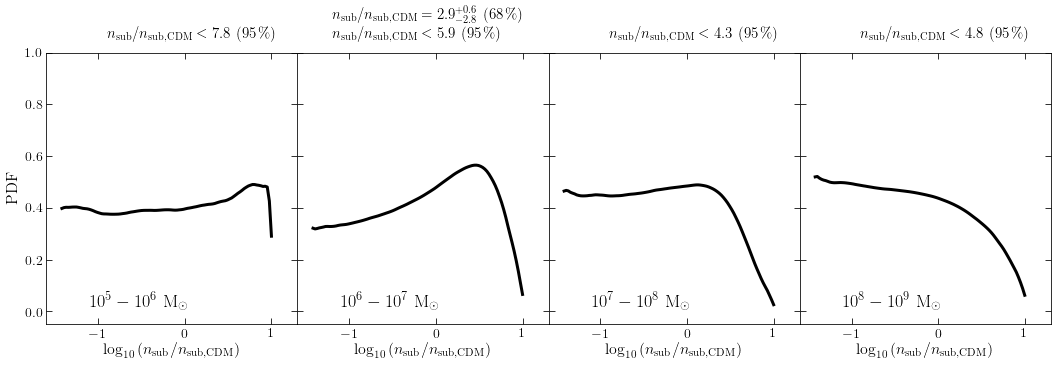

In [7]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
plt.figure(figsize=(18,5))
ax1=plt.subplot(1,4,1)
ax1.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.,labelbottom=True) 
plot_pdf(accepted_x1,xloc=-0.9,yloc=1.05,color='k',dat_type='rate',fontsize=15,add_95up=True,\
         add_95low=False,kernel_width=0.5,overplot=True)
#xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$')
xlabel(r'$\log_{10}\left(n_{\rm{sub}}/n_{\rm{sub, CDM}}\right)$',fontsize=16)
ylabel(r'$\mathrm{PDF}$',fontsize=16)
xlim(-1.6,1.3)
ylim(-0.05,1.)
text(-1.1,0.01,r'$10^{5}-10^{6} \ \rm{M}_{\odot}$',fontsize=18)
#plt.legend(loc='lower left',fontsize=16)
#plt.ylim(200,4200)
#plt.xlabel([])
#plt.xtick_labelsize=0.


ax2=plt.subplot(1,4,2)
ax2.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.,labelbottom=True) 
plot_pdf(accepted_x2,xloc=-1.2,yloc=1.05,color='k',dat_type='rate',fontsize=15,add_68peak_95up=True,\
         add_95up=False,add_95low=False,kernel_width=0.6,overplot=True)
text(-1.1,0.01,r'$10^{6}-10^{7} \ \rm{M}_{\odot}$',fontsize=18)
xlabel(r'$\log_{10}\left(n_{\rm{sub}}/n_{\rm{sub, CDM}}\right)$',fontsize=16)
#ylabel(r'$\mathrm{PDF}$')
xlim(-1.6,1.3)
ylim(-0.05,1.)
#plt.xtick_labelsize=0.
#plt.ytick_labelsize=0.
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
#plt.xticks([])
#plt.ylabel('Star count',fontsize=16)
#plt.legend(loc='lower left',fontsize=16)

ax3=plt.subplot(1,4,3)
ax3.tick_params(axis='both',direction='in',which='both',left=True,top=True,right=True,length=6.) 
plot_pdf(accepted_x3,xloc=-0.9,yloc=1.05,color='k',dat_type='rate',fontsize=15,add_68peak_95up=False,\
         add_95up=True,add_95low=False,kernel_width=0.6,overplot=True)
text(-1.1,0.01,r'$10^{7}-10^{8} \ \rm{M}_{\odot}$',fontsize=18)
xlabel(r'$\log_{10}\left(n_{\rm{sub}}/n_{\rm{sub, CDM}}\right)$',fontsize=16)
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
#ylabel(r'$\mathrm{PDF}$',fontsize=16)
#plt.legend(loc='lower left',fontsize=16)
xlim(-1.6,1.3)
ylim(-0.05,1.)

ax3=plt.subplot(1,4,4)
ax3.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.) 
plot_pdf(accepted_x4,xloc=-0.9,yloc=1.05,color='k',dat_type='rate',fontsize=15,add_68peak_95up=False,add_95up=True,add_95low=False,kernel_width=0.8,overplot=True)
text(-1.1,0.01,r'$10^{8}-10^{9} \ \rm{M}_{\odot}$',fontsize=18)
xlabel(r'$\log_{10}\left(n_{\rm{sub}}/n_{\rm{sub, CDM}}\right)$',fontsize=16)
#ylabel(r'$\mathrm{PDF}$')
#plt.legend(loc='lower left',fontsize=16)
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
xlim(-1.6,1.3)
ylim(-0.05,1.)



plt.subplots_adjust(wspace=0, hspace=0)
savefig("ABC_posterior_4bins_LSST_x10_model_0.pdf",bbox_inches='tight')
plt.show()

### mock data from David

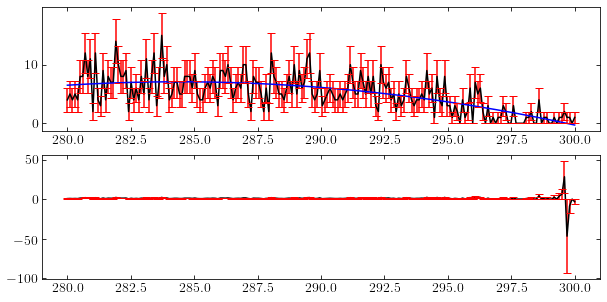

In [8]:
def compute_nden_mock(fname,nmodel=0,polydeg=3):
    _Lambdas=np.linspace(280.,300.,200)
    _Ndn=np.loadtxt(fname)[nmodel]
    
    Lambdas = _Lambdas[_Lambdas <= 300.]
    Ndn=_Ndn[_Lambdas <= 300.]
    #print (lam)
    #print (np.sum(Ndn))
    Ndn_err=numpy.sqrt(Ndn)
       
    pp= Polynomial.fit(Lambdas,Ndn,deg=polydeg)
    nden=Ndn/pp(np.array(Lambdas))
    nden_err=np.sqrt(Ndn)/pp(np.array(Lambdas))
       
    return (Lambdas,Ndn,Ndn_err,nden,nden_err,pp(np.array(Lambdas)))

nn=1
fn = "../LSST_galaxia_new"

Lambdas=np.linspace(280.,299.9,200)
lam,N,N_err,nden,nden_err,pp = compute_nden_mock(fn,nmodel=nn)


plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(lam,N,c='k')
plt.plot(lam,pp,c='b')
plt.errorbar(lam,N,N_err,marker='None',ls='None',capsize=4.,ecolor='r')

plt.subplot(2,1,2)
plt.plot(lam,nden,c='k')
plt.errorbar(lam,nden,nden_err,marker='None',ls='None',capsize=4.,ecolor='r')
plt.savefig("density_norm_density_LSST_Galaxia_{}.pdf".format(nn))
plt.show()

/home/nil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: divide by zero encountered in true_divide

/home/nil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in sqrt



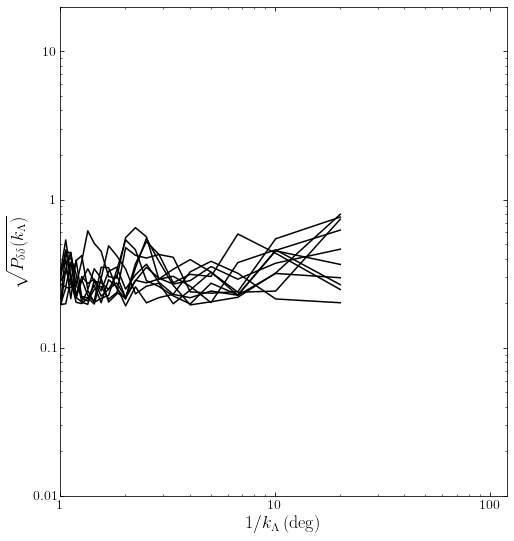

In [9]:
figsize(8,9)

for mn in range(10):
    
    try :
        px_dat,ppy_noise_median,ppy_noise_low,ppy_noise_high,py_err_dat = compute_pk_mock(fname="../LSST_galaxia_new",\
                                                                                   nmodel=mn)
        loglog(px_dat,ppy_noise_median,color='black',zorder=10)
    
        set_ranges_and_labels_dens()
        plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\Lambda})}$',fontsize=18)
    except LinAlgError:
        pass
        

savefig("Pk_LSST_galaxia_cut.pdf")



In [ ]:
folder = "../dens_Omega/Phx_dens_Omega_4bins_10/"

nn=0
fn = "../LSST_galaxiax10_new"
px_dat,ppy_noise_median,ppy_noise_low,ppy_noise_high,py_err_dat = compute_pk_model(fname=fn,\
                                                                                   nmodel=nn)

figsize(8,9)
loglog(px_dat,ppy_noise_median,color='red',zorder=10,ls='--')
for fname in glob.glob(folder + '*.dat'):
    _,_,_,_,ll,densl= compute_obs_dens_from_file_4bin(fname)

    _,dens_cont = compute_dens_cont(ll,densl,deg=3)
    px0,py0 = compute_pk_sim(ll,dens_cont)
    loglog(px0,py0,color='black')
    set_ranges_and_labels_dens()
    plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\Lambda})}$',fontsize=18)

    #ppy= numpy.empty((N,len(px0)))
    #ppy[0]=numpy.sqrt(py*(ll[-1]-ll[0]))

savefig("Pk_10xCDM.pdf")


In [ ]:
# plot observed density of the smooth stream

In [ ]:
    
#check smooth density and apars
apar=np.linspace(0.0,1.75,200)
dens_unp= [sdf_smooth_t._density_par(a) for a in apar]
omega_unp= [sdf_smooth_t.meanOmega(a,oned=True) for a in apar]

plt.figure()
plt.plot(apar,dens_unp)
plt.show()

Lambdas=np.linspace(280.,299.9,200)
          
dens_lam = compute_obs_density_phx(Lambdas,apar,dens_unp,omega_unp)



print (0.2*np.mean(dens_lam[Lambdas<282.]))

print (Lambdas[np.argmin(fabs(dens_lam-0.2*np.mean(dens_lam[Lambdas<282.])))])

plt.figure()
plt.plot(Lambdas,dens_lam)
plt.hlines(0.2*np.mean(dens_lam[Lambdas<282.]),280,300)
plt.show()

In [ ]:
#sample points from the stream

lb_sample_sm=sdf_pepper_t.sample(n=2000,lb=True)
l_sm=lb_sample_sm[0]
b_sm=lb_sample_sm[1]




plt.figure()
plt.subplot(2,1,1)
plt.scatter(l_sm,b_sm,s=0.5)
plt.xlabel(r"$\ell$ (deg)")
plt.ylabel(r"$b$ (deg)")

lam,bet = lb_to_lamdabeta(l_sm,b_sm)


plt.subplot(2,1,2)
plt.scatter(lam,bet,s=0.5)
plt.xlabel(r"$\Lambda$ (deg)")
plt.ylabel(r"$\beta$ (deg)")

print (min(lam),max(lam))


In [ ]:
#pick the model with the most power

fn = "../LSST_galaxiax10_new"

Lambdas=np.linspace(280.,299.9,200)

py1=[]
py2=[]
py3=[]
py4=[]

for nn in range(100):
    print (nn)
    
    try:
        px_dat,ppy_noise_median,ppy_noise_low,ppy_noise_high,py_err_dat = compute_pk_model(fname=fn,\
                                                                                   nmodel=nn)
        py1.append(ppy_noise_median[0])
        py2.append(ppy_noise_median[1])
        
    except LinAlgError:
        print ("error")
        py1.append(0.)
        py2.append(0.)
    
print (argmax(py1),argmax(py2))

    

In [ ]:
#generate random rates in the 4 mass bins

ratemax = 1.
ratemin = -1.5

fo=open("rate0p1_1K.dat","w")

for ll in range(1000):
    #randrate=numpy.random.uniform(size=4)*(ratemax-ratemin)+ratemin
    #randrate=10**(randrate)
    #fo.write(str(randrate[0]) + "  " + str(randrate[1]) + "  " + str(randrate[2]) + "  " + str(randrate[3]) + "\n")
    fo.write(str(0.1) + "  " + str(0.1) + "  " + str(0.1) + "  " + str(0.1) + "\n")

fo.close()

In [ ]:
obs_phx = Orbit([27.60969888973802*u.deg,
  -43.54155350527743*u.deg,
  17.624735997461556*u.kpc,
  2.19712949699425679*(u.mas/u.yr),
  -0.5240686072157521*(u.mas/u.yr),
  19.93208180482703*(u.km/u.s)], \
                    radec=True,ro=8,vo=220, \
                    solarmotion=[-11.1,24.,7.25])

ts=np.linspace(0.,-4.,1000)/bovy_conversion.time_in_Gyr(220.,8.)
obs_phx.integrate(ts,MWPotential2014)

obs_phx.plot()

sp_r = np.array([obs_phx.r(ii) for ii in ts])

print (np.mean(sp_r))

In [ ]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
def compute_pk_data(phi1,norm_den,norm_den_err):
    
    px_dat,py_dat= signal.csd(norm_den,norm_den,fs=1./(phi1[1]-phi1[0]),scaling='spectrum',nperseg=len(phi1))
    py_dat= py_dat.real
    px_dat= 1./px_dat
    py_dat= numpy.sqrt(py_dat*(phi1[-1]-phi1[0]))
           
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err_dat= numpy.empty((nerrsim,len(px_dat)))

    ppy_noise=numpy.empty((nerrsim,len(px_dat)))

    for ii in range(nerrsim):
        tmock= norm_den_err*numpy.random.normal(size=len(phi1))
        tmock_noise= norm_den + norm_den_err*numpy.random.normal(size=len(phi1))
        ppy_err_dat[ii]= signal.csd(tmock,tmock,
                                fs=1./(phi1[1]-phi1[0]),scaling='spectrum',
                                nperseg=len(phi1))[1].real

        ppy_noise[ii]= signal.csd(tmock_noise,tmock_noise,
                                fs=1./(phi1[1]-phi1[0]),scaling='spectrum',
                                nperseg=len(phi1))[1].real

    py_err_dat= numpy.sqrt(numpy.median(ppy_err_dat,axis=0)*(phi1[-1]-phi1[0]))

    ppy_noise_median = numpy.sqrt(numpy.nanmedian(ppy_noise,axis=0)*(phi1[-1]-phi1[0]))
    #print (ppy_noise_median- py_dat)

    ppy_noise.sort(axis=0)

    ppy_noise_low = numpy.sqrt(ppy_noise[int(numpy.round(0.023*nerrsim))]*(phi1[-1]-phi1[0]))
    ppy_noise_high = numpy.sqrt(ppy_noise[int(numpy.round(0.977*nerrsim))]*(phi1[-1]-phi1[0]))
    
    return (px_dat,ppy_noise_median,ppy_noise_low,ppy_noise_high,py_err_dat)





def compute_dens_cont(lamda,dens_lamda,deg=3):
    Lambdas=np.linspace(280.,293,200)
    ip_dens_lamda=interpolate.InterpolatedUnivariateSpline(lamda,dens_lamda)

    #compute polynomial and density at outphi1
    ppdens_lamda= Polynomial.fit(Lambdas,ip_dens_lamda(Lambdas),deg=deg)

    #compute density contrast
    dens_cont=ip_dens_lamda(Lambdas)/ppdens_lamda(Lambdas)
    
    return (Lambdas,dens_cont)







            
            

In [ ]:
compute_power_diff_4bins(mod_no=0,RaoblackwellizeN=0)

In [ ]:
print (accepted_x2[0:10])
print (np.log10(accepted_x2[0:10]))

plt.figure()
plt.hist(np.log10(accepted_x2))

plt.show()

In [ ]:
rr=np.linspace(-1.5,1.,25)

bw=rr[1]-rr[0]


rredge=[rr[0] + i*bw for i in range(len(rr)+1)]

#print (rredge)

count1,bin_edge=np.histogram(accepted_x1,rredge)
count2,bin_edge=np.histogram(accepted_x2,rredge)
count3,bin_edge=np.histogram(accepted_x3,rredge)
count4,bin_edge=np.histogram(accepted_x4,rredge)

rand=np.loadtxt("../random_4bin_rate_100K.dat")

plt.figure()
plt.subplot(2,2,1)
plt.hist(np.log10(accepted_x1),bins=15,density=True)
#plt.hist(np.log10(rand[:,0]),bins=15,density=True)
#plt.plot(rr,count1,label=r'5-6')
plt.legend(loc='upper left')
plt.subplot(2,2,2)
plt.hist(np.log10(accepted_x2),bins=15,density=True)
#plt.plot(rr,count2,label=r'6-7')
plt.legend(loc='upper left')
plt.subplot(2,2,3)
plt.hist(np.log10(accepted_x3),bins=15,density=True)
#plt.plot(rr,count3,label=r'7-8')
plt.legend(loc='upper left')
plt.subplot(2,2,4)
plt.hist(np.log10(accepted_x4),bins=15,density=True)
#plt.plot(rr,count4,label=r'8-9')
#plt.legend(loc='upper left')
plt.savefig("posterior_4bins_LSSTgalaxiax10_0.pdf")
plt.show()




In [ ]:
folder = "../dens_Omega/Phx_dens_Omega_4bins_10/"

nn=0
fn = "../LSST_galaxiax10_new"
px_dat,ppy_noise_median,ppy_noise_low,ppy_noise_high,py_err_dat = compute_pk_model(fname=fn,\
                                                                                   nmodel=nn)

figsize(8,9)
loglog(px_dat,ppy_noise_median,color='red',zorder=10,ls='--')
for fname in glob.glob(folder + '*.dat'):
    _,_,_,_,ll,densl= compute_obs_dens_from_file_4bin(fname)

    _,dens_cont = compute_dens_cont(ll,densl,deg=3)
    px0,py0 = compute_pk_sim(ll,dens_cont)
    loglog(px0,py0,color='black')
    set_ranges_and_labels_dens()
    plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\Lambda})}$',fontsize=18)

    #ppy= numpy.empty((N,len(px0)))
    #ppy[0]=numpy.sqrt(py*(ll[-1]-ll[0]))

savefig("Pk_10xCDM.pdf")




In [ ]:
folder = "../dens_Omega/Phx_dens_Omega_4bins_1/"

nn=0
fn = "../LSST_galaxiax10_new"
px_dat,ppy_noise_median,ppy_noise_low,ppy_noise_high,py_err_dat = compute_pk_model(fname=fn,\
                                                                                   nmodel=nn)

figsize(8,9)
loglog(px_dat,ppy_noise_median,color='red',zorder=10,ls='--')
for fname in glob.glob(folder + '*.dat'):
    _,_,_,_,ll,densl= compute_obs_dens_from_file_4bin(fname)

    _,dens_cont = compute_dens_cont(ll,densl,deg=3)
    px0,py0 = compute_pk_sim(ll,dens_cont)
    loglog(px0,py0,color='black')
    set_ranges_and_labels_dens()
    plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\Lambda})}$',fontsize=18)

    #ppy= numpy.empty((N,len(px0)))
    #ppy[0]=numpy.sqrt(py*(ll[-1]-ll[0]))


savefig("Pk_1xCDM.pdf")




In [ ]:
folder = "../dens_Omega/Phx_dens_Omega_4bins_0p1/"

nn=0
fn = "../LSST_galaxiax10_new"
px_dat,ppy_noise_median,ppy_noise_low,ppy_noise_high,py_err_dat = compute_pk_model(fname=fn,\
                                                                                   nmodel=nn)

figsize(8,9)
loglog(px_dat,ppy_noise_median,color='red',zorder=10,ls='--')
for fname in glob.glob(folder + '*.dat'):
    _,_,_,_,ll,densl= compute_obs_dens_from_file_4bin(fname)

    _,dens_cont = compute_dens_cont(ll,densl,deg=3)
    px0,py0 = compute_pk_sim(ll,dens_cont)
    loglog(px0,py0,color='black')
    set_ranges_and_labels_dens()
    plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\Lambda})}$',fontsize=18)

    #ppy= numpy.empty((N,len(px0)))
    #ppy[0]=numpy.sqrt(py*(ll[-1]-ll[0]))

savefig("Pk_0p1xCDM.pdf")





In [ ]:
h=0.6774
ro=8.
vo=220.


def alpha(m_wdm):
    return (0.048/h)*(m_wdm)**(-1.11) #in Mpc , m_wdm in keV

def lambda_hm(m_wdm):
    nu=1.12
    return 2*numpy.pi*alpha(m_wdm)/(2**(nu/5.) - 1.)**(1/(2*nu))

def M_hm(m_wdm):
    Om_m=0.3089
    rho_c=1.27*10**11 #Msun/Mpc^3 
    rho_bar=Om_m*rho_c
    return (4*numpy.pi/3)*rho_bar*(lambda_hm(m_wdm)/2.)**3

def Einasto(r):
    al=0.678 #alpha_shape
    rm2=199 #kpc, see Erkal et al 1606.04946 for scaling to M^1/3
    return numpy.exp((-2./al)*((r/rm2)**al -1.))*4*numpy.pi*(r**2)

def dndM_cdm(M,c0kpc=2.02*10**(-13),mf_slope=-1.9):
    #c0kpc=2.02*10**(-13) #Msun^-1 kpc^-3 from Denis' paper
    m0=2.52*10**7 #Msun from Denis' paper
    return c0kpc*((M/m0)**mf_slope)

def nsub_cdm(M1,M2,r=15.6,c0kpc=2.02*10**(-13),mf_slope=-1.9):
    #number density of subhalos in kpc^-3
    m1=10**(M1)
    m2=10**(M2)
    return integrate.quad(dndM_cdm,m1,m2,args=(c0kpc,mf_slope))[0]*integrate.quad(Einasto,0.,r)[0]*(8.**3.)/(4*numpy.pi*(r**3)/3) #in Galpy units


def compute_rate(rand_params,sdf_pepper,mf_slope=-1.9,c0kpc=2.02*10**(-13),Xrs=5.,sigma=120./220.):
    Mbin_edge=[5.,6.,7.,8.,9.]
    Nbins=len(Mbin_edge)-1
    #compute number of subhalos in each mass bin and multiply rand_params
    nden_bin=np.empty(Nbins)
    rate_bin=np.empty(Nbins)
    for ll in range(Nbins):
        nden_bin[ll]=nsub_cdm(Mbin_edge[ll],Mbin_edge[ll+1])*rand_params[ll] #fiducial CDM
        Mmid=10**(0.5*(Mbin_edge[ll]+Mbin_edge[ll+1]))
        rate_bin[ll]=sdf_pepper.subhalo_encounters(sigma=sigma,nsubhalo=nden_bin[ll],bmax=Xrs*rs(Mmid,plummer=True))

    rate = np.sum(rate_bin)
    
    return (rate,rate_bin)    

print (compute_rate([1,1,1,1],sdf_pepper_t))
print (compute_rate([10,10,10,10],sdf_pepper_t))

In [ ]:
for fname in glob.glob( + '*.dat'):
    



def pk_scatter(phys_coord_file,N=1000):
    
    if arm == 'leading' :
        phi1_min=-60.
        phi1_max=prog -(gap_width*0.5)  #-42. 
        
    else :
        phi1_min=prog+(gap_width*0.5) #-38.
        phi1_max=-4.  
    
    
    with open(phys_coord_file) as f:
        for jj in range(1):
            phi1_string = next(f).split(',')
    ll = np.array([float(ii) for ii in phi1_string])
    print (ll)
    dens_file = np.loadtxt(phys_coord_file,delimiter=',',skiprows=1)
    #N=len(dens_file)
    print (N)
    
    tdata=dens_file[0]
    px,py= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))
    py= py.real

    ppy= numpy.empty((N,len(px)))
    ppy[0]=numpy.sqrt(py*(ll[-1]-ll[0]))
        
    for ii in range(1,N):
        tdata=dens_file[ii]
        ppy[ii]= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))[1].real
            
    if not scatter:
            
        return (1./px,numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0])))
        
    else:
        out= numpy.sqrt(numpy.nanmedian(ppy,axis=0)*numpy.abs(ll[-1]-ll[0]))
                
        ppy.sort(axis=0)
        
        return (1./px,out,
                #numpy.sqrt(ppy[int(numpy.round(0.25*N))]*(ll[-1]-ll[0])),
                #numpy.sqrt(ppy[int(numpy.round(0.75*N)-1)]*(ll[-1]-ll[0])))
                numpy.sqrt(ppy[int(numpy.round(0.023*N))]*(ll[-1]-ll[0])),
                numpy.sqrt(ppy[int(numpy.round(0.977*N)-1)]*(ll[-1]-ll[0])))
                #numpy.sqrt(ppy[int(numpy.round(0.159*N))]*(ll[-1]-ll[0])),
                #numpy.sqrt(ppy[int(numpy.round(0.84*N)-2)]*(ll[-1]-ll[0])))
            
            
def plot_pk_scatter(phys_coord_file,gap_width=12.,N=1000,arm='trailing',color='k',zorder=1,ls='-',
              fill=True,fill_color='k',fill_zorder=0,label=''):
    
    
    px, py= pk_scatter(phys_coord_file,N=N,arm=arm,gap_width=gap_width)
    #print (px)
    loglog(px,py,lw=2.,color=color,zorder=zorder,ls=ls,label=label)
    
    if fill:
        plotx, dum, low, high= pk_scatter(phys_coord_file,N=N,arm=arm,scatter=True,gap_width=gap_width)
    
        fill_between(plotx,low,high,color=fill_color,zorder=fill_zorder,alpha=0.5)
        #errorbar(plotx,py,yerr=[py-low,py+high],color=color,fmt='o',capsize=5.,capthick=1.,ecolor=color)
        #set_yscale('log')
        #set_xscale('log')
    
    if label != '':
        legend(loc='upper left',fontsize=12)    
    return None

In [ ]:
import seaborn as sns
def kde_epanechnikov_rate(x,h,ydata):
    """ydata= ln[(2+xdata)/(2-xdata)]"""
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((2.1+x)/(2.1-x))
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(2.1+x)+1./(2.1-x))




In [ ]:
#collect all the densOmega files, convert them to observed coordinates and write them out to a single file



folder = "../dens_Omega/Phx_dens_Omega_4bins_randrate-1p5_1/"

fname = folder + 'Phx_4bin_densOmega_onlysubhalo_Plummer_Mmin105_16470.dat'
x1,x2,x3,x4,ll,densl= compute_obs_dens_from_file_4bin(fname)

print (x1,x2,x3,x4)

plt.figure()
plt.plot(ll,densl)
#plt.plot(Lambda_bins,phx_dens1)
plt.show()

In [ ]:
range_ind=1
ind_min = 5000
ind_max = 100000

cores = 200

njobs_per_core = (ind_max - ind_min)/cores

print (njobs_per_core)

for ii in range(int(ind_min+(njobs_per_core*range_ind)),int(ind_min+((njobs_per_core*(range_ind+1))))):
    print (ii)


In [ ]:
for ind in range(int(ind_min+(njobs_per_core*range_ind)),int(ind_min+((njobs_per_core*(range_ind+1))))):
    print (ind)
    rand_params=np.loadtxt('random_4bin_rate_100K.dat')[ind][:4]
    print (rand_params)     
    rate,_ = compute_rate(rand_params,sdf_pepper)   

    print (rate)
    fo=open(folder + 'Phx_4bin_densOmega_onlysubhalo_Plummer_Mmin105_{}.dat'.format(ind),'w')
    fo.write('#x1 x2 x3 x4 apar   dens_unp   dens  omega_unp   omega' + '\n')

    if rate > 2000.:
        print (rate,"FUBAR!")
        apar_out=np.linspace(0.0,1.75,200)
        dens_unp= [sdf_smooth._density_par(a) for a in apar_out]
        omega_unp= [sdf_smooth.meanOmega(a,oned=True) for a in apar_out]       

        for  ii in range(len(apar_out)):
            fo.write(str(rand_params[0])+'    '+str(rand_params[1])+'    '+str(rand_params[2])+'    '+str(rand_params[3]) +'    ' + str(apar_out[ii]) + '   ' + str(dens_unp[ii]) + '   ' + str(0.00001) + '   ' + str(omega_unp[ii]) + '   ' + str(0.00001) + '\n' )

        fo.close()                                                                                  

    else:
        impact_angle_sub,impactb_sub,subhalovel_sub,timpact_sub,GM_sub,rs_sub = \
                simulate_subhalos(rand_params,sdf_pepper,mf_slope=-1.9,c0kpc=2.02*10**(-13),Xrs=5.)    

        print ('%i subhalo impact'%len(GM_sub))   
        if len(GM_sub) == 0 : #no hits
            print ("no hits")
            apar_out=np.linspace(0.0,1.75,200)
            dens_unp= [sdf_smooth._density_par(a) for a in apar_out]
            omega_unp= [sdf_smooth.meanOmega(a,oned=True) for a in apar_out]

            for  jj in range(len(apar_out)):
                fo.write(str(rand_params[0])+'    '+str(rand_params[1])+'    '+str(rand_params[2])+'    '+str(rand_params[3]) + '    ' + str(apar_out[jj]) + '   ' + str(dens_unp[jj]) + '   ' + str(dens_unp[jj]) + '   ' + str(omega_unp[jj]) + '   ' + str(omega_unp[jj]) + '\n' )

        fo.close()

        else :

            # Flip angle sign if necessary
            if not sdf_pepper._gap_leading: impact_angle_sub*= -1.     

            sdf_pepper.set_impacts(impactb=impactb_sub,subhalovel=subhalovel_sub,impact_angle=impact_angle_sub,\
                                   timpact=timpact_sub,rs=rs_sub,GM=GM_sub)

            apar_out=np.linspace(0.0,1.75,200)

            dens_unp= [sdf_smooth._density_par(a) for a in apar_out]
            omega_unp= [sdf_smooth.meanOmega(a,oned=True) for a in apar_out]
            densOmega= np.array([sdf_pepper._densityAndOmega_par_approx(a) for a in apar_out]).T

            for  jj in range(len(apar_out)):
                fo.write(str(rand_params[0])+'    '+str(rand_params[1])+'    '+str(rand_params[2])+'    '+str(rand_params[3]) + '    ' + str(apar_out[jj]) + '   ' + str(dens_unp[jj]) + '   ' + str(densOmega[0][jj]) + '   ' + str(omega_unp[jj]) + '   ' + str(densOmega[1][jj]) + '\n' )

        fo.close()
